# Neccesary modules 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# Get the data

In [2]:
background = np.load("data/background_rf_LH_normalized.npy")
drone = np.load("data/drone_rf_LH_normalized.npy")

In [5]:
print(background.shape)
print(drone.shape)

(41, 2, 10000000, 1)
(39, 2, 10000000, 1)


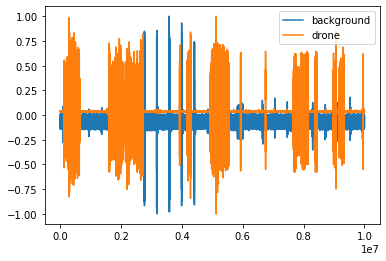

In [5]:
num = random.randint(0, len(background)-1)
channel = 0
plt.plot(background[num][channel], label="background")
plt.plot(drone[num][channel],label="drone")
plt.legend(loc='upper right')

In [ ]:
plt.plot(np.fft.rfft(background[num][channel]), label="background")
plt.plot(np.fft.rfft(drone[num][channel]),label="drone")
plt.legend(loc='upper right')

# Train/ test split and data formatting

In [6]:
Y = np.array([0 for i in enumerate(background)] + [1 for i in enumerate(drone)])
X = np.append(background,drone,axis=0)
Y = Y.reshape(-1,1)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [9]:
def split_rf(x_data):
    low = []
    high = []
    for x in x_data:
        low.append(x[0].astype(np.float16))
        high.append(x[1].astype(np.float16))
    low = np.array(low)
    high = np.array(high)
    return [low, high]
x_train = split_rf(x_train)
x_test = split_rf(x_test)
    

In [17]:
x_train[0].shape

(56, 10000000)

# Model Specification

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, concatenate, LSTM, Dropout
from tensorflow.keras.layers import Input


# define two sets of inputs
low_rf  = Input(shape=(X.shape[2],1))
high_rf = Input(shape=(X.shape[2],1))

# the first branch operates on the first input
x1 = LSTM(10)(low_rf)
x1 = Dropout(0.5)(x1)
x1 = Dense(10, activation="relu")(x1)
x1 = Model(inputs=low_rf, outputs=x1)

# the second branch operates on the second input
x2 = LSTM(10)(high_rf)
x2 = Dropout(0.5)(x2)
x2 = Dense(10, activation="relu")(x2)
x2 = Model(inputs=high_rf, outputs=x2)

# combine the output of the two branches
combined = concatenate([x1.output, x2.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(10, activation="relu")(combined)
z = Dense(1, activation="sigmoid")(z)

model = Model(inputs=[x1.input, x2.input], outputs=z)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10000000, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10000000, 1) 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 10)           480         input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 10)           480         input_2[0][0]                    
____________________________________________________________________________________________

In [11]:
model.compile(optimizer ='adam' , loss = "binary_crossentropy", metrics=["accuracy"])

# Train Model

In [12]:
batch_size =1
epochs = 10
# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1)
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 56 samples, validate on 24 samples
Epoch 1/10
 1/56 [..............................] - ETA: 7:04:15

ResourceExhaustedError:  [_Derived_]  OOM when allocating tensor with shape[10000000,1,10] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradients/strided_slice_grad/StridedSliceGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[StatefulPartitionedCall_1]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_6240]

Function call stack:
distributed_function -> distributed_function -> distributed_function
